# 🎯 Physics Fundamentals for TrajectoryForge

Welcome to the first notebook in the TrajectoryForge series! In this notebook, we'll build intuition for 2D physics simulation and understand the different force fields available in our game.

## What You'll Learn

1. **Basic 2D Physics**: Position, velocity, acceleration, and forces
2. **Numerical Integration**: How we simulate physics over time
3. **Force Fields**: Wind, vortex, point forces, gravity wells, and drag zones
4. **Visualization**: How to see trajectories and force fields

## Prerequisites

- Basic Python and NumPy knowledge
- High school physics (F = ma)
- No machine learning required yet!

Let's get started! 🚀


In [1]:
# Setup and imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, FancyArrow
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
from IPython.display import HTML
from matplotlib import animation

# For interactive widgets
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed

# Set up nice plotting defaults
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 12

print("✅ All imports successful!")


✅ All imports successful!


## Part 1: The Basics of 2D Physics

### Newton's Second Law

The foundation of our physics simulation is Newton's second law:

$$\vec{F} = m \vec{a}$$

Or rearranged to find acceleration:

$$\vec{a} = \frac{\vec{F}}{m}$$

In 2D, we track:
- **Position**: $\vec{x} = (x, y)$ - where the ball is
- **Velocity**: $\vec{v} = (v_x, v_y)$ - how fast and in what direction it's moving
- **Acceleration**: $\vec{a} = (a_x, a_y)$ - how velocity is changing

The relationships between these are:
$$\vec{v} = \frac{d\vec{x}}{dt}, \quad \vec{a} = \frac{d\vec{v}}{dt}$$


In [2]:
# Let's define a simple physics state
class PhysicsState:
    """Simple physics state for a 2D particle."""
    def __init__(self, x=0.0, y=0.0, vx=0.0, vy=0.0):
        self.position = np.array([x, y], dtype=np.float64)
        self.velocity = np.array([vx, vy], dtype=np.float64)
    
    def __repr__(self):
        return f"PhysicsState(pos={self.position}, vel={self.velocity})"

# Create a ball starting at origin, moving to the right
ball = PhysicsState(x=0, y=0, vx=2.0, vy=1.0)
print(f"Initial state: {ball}")
print(f"Speed: {np.linalg.norm(ball.velocity):.2f} m/s")


Initial state: PhysicsState(pos=[0. 0.], vel=[2. 1.])
Speed: 2.24 m/s


### Numerical Integration: Euler's Method

To simulate physics, we need to update position and velocity over small time steps. The simplest approach is **Euler's method**:

$$\vec{v}_{n+1} = \vec{v}_n + \vec{a} \cdot \Delta t$$
$$\vec{x}_{n+1} = \vec{x}_n + \vec{v}_n \cdot \Delta t$$

We use a slightly better variant called **Semi-Implicit Euler** (or Symplectic Euler):

$$\vec{v}_{n+1} = \vec{v}_n + \vec{a} \cdot \Delta t$$
$$\vec{x}_{n+1} = \vec{x}_n + \vec{v}_{n+1} \cdot \Delta t$$

The key difference: we use the *new* velocity to update position. This conserves energy better!


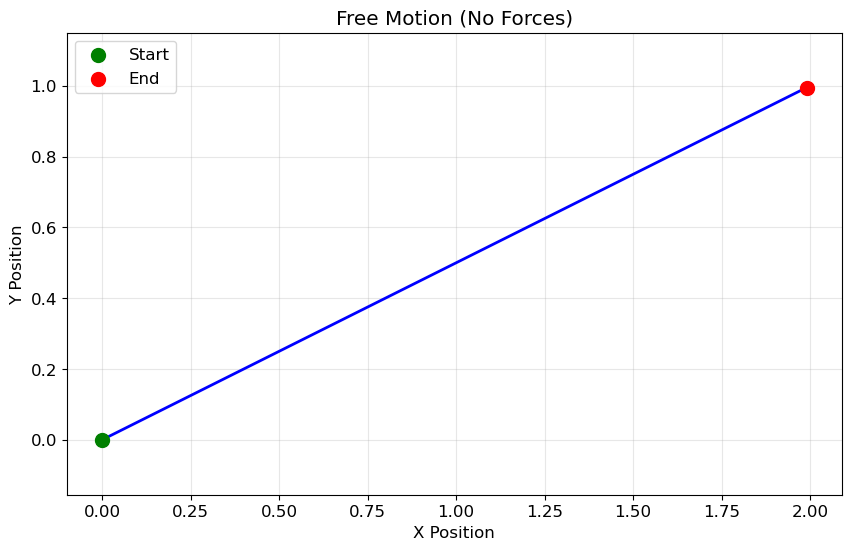

In [3]:
def simulate_simple(initial_state, force_fn, dt=0.01, num_steps=500, mass=1.0):
    """
    Simulate physics using semi-implicit Euler integration.
    
    Args:
        initial_state: PhysicsState with initial position and velocity
        force_fn: Function that takes (position, velocity) and returns force vector
        dt: Time step
        num_steps: Number of simulation steps
        mass: Particle mass
    
    Returns:
        positions: Array of shape (num_steps, 2)
        velocities: Array of shape (num_steps, 2)
    """
    positions = np.zeros((num_steps, 2))
    velocities = np.zeros((num_steps, 2))
    
    pos = initial_state.position.copy()
    vel = initial_state.velocity.copy()
    
    for i in range(num_steps):
        # Record current state
        positions[i] = pos
        velocities[i] = vel
        
        # Compute force and acceleration
        force = force_fn(pos, vel)
        acc = force / mass
        
        # Semi-implicit Euler: update velocity first, then position
        vel = vel + acc * dt
        pos = pos + vel * dt
    
    return positions, velocities

# Test with no force (should be straight line)
def no_force(pos, vel):
    return np.array([0.0, 0.0])

state = PhysicsState(x=0, y=0, vx=1.0, vy=0.5)
positions, velocities = simulate_simple(state, no_force, dt=0.01, num_steps=200)

plt.figure(figsize=(10, 6))
plt.plot(positions[:, 0], positions[:, 1], 'b-', linewidth=2)
plt.scatter([positions[0, 0]], [positions[0, 1]], c='green', s=100, zorder=5, label='Start')
plt.scatter([positions[-1, 0]], [positions[-1, 1]], c='red', s=100, zorder=5, label='End')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Free Motion (No Forces)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()


## Part 2: Force Fields

Now let's add forces! In TrajectoryForge, we have several types of force fields that the player can place to guide the ball.

### 2.1 Uniform Wind Field

A wind field applies a constant force in a specific direction within a rectangular region.

$$\vec{F}_{wind} = \text{strength} \cdot \hat{d} \cdot \mathbb{1}_{box}(\vec{x})$$

where $\hat{d}$ is the wind direction and $\mathbb{1}_{box}$ is an indicator function for being inside the box.


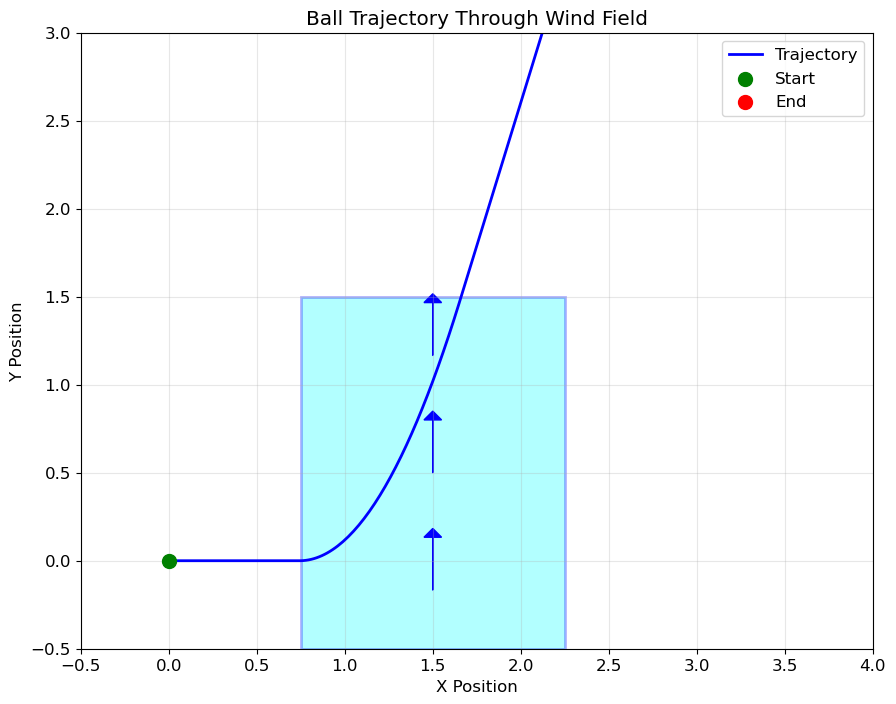

In [4]:
class WindField:
    """Uniform wind force in a rectangular region."""
    def __init__(self, center, size, direction, strength):
        self.center = np.array(center)
        self.size = np.array(size)  # width, height
        self.direction = np.array(direction)
        self.direction = self.direction / np.linalg.norm(self.direction)  # normalize
        self.strength = strength
    
    def is_inside(self, pos):
        """Check if position is inside the wind region."""
        half_size = self.size / 2
        return (abs(pos[0] - self.center[0]) < half_size[0] and 
                abs(pos[1] - self.center[1]) < half_size[1])
    
    def compute_force(self, pos, vel):
        """Compute force at position."""
        if self.is_inside(pos):
            return self.strength * self.direction
        return np.array([0.0, 0.0])

# Create a wind field pushing upward
wind = WindField(center=(1.5, 0.5), size=(1.5, 2.0), direction=(0, 1), strength=8.0)

# Simulate with wind
def wind_force(pos, vel):
    return wind.compute_force(pos, vel)

state = PhysicsState(x=0, y=0, vx=1.5, vy=0.0)
positions, _ = simulate_simple(state, wind_force, dt=0.01, num_steps=300)

# Visualize
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(positions[:, 0], positions[:, 1], 'b-', linewidth=2, label='Trajectory')
ax.scatter([0], [0], c='green', s=100, zorder=5, label='Start')
ax.scatter([positions[-1, 0]], [positions[-1, 1]], c='red', s=100, zorder=5, label='End')

# Draw wind region
rect = Rectangle(wind.center - wind.size/2, wind.size[0], wind.size[1], 
                 fill=True, facecolor='cyan', alpha=0.3, edgecolor='blue', linewidth=2)
ax.add_patch(rect)

# Draw wind direction arrows
for y in np.linspace(wind.center[1] - wind.size[1]/3, wind.center[1] + wind.size[1]/3, 3):
    ax.arrow(wind.center[0], y, 0, 0.3, head_width=0.1, head_length=0.05, fc='blue', ec='blue')

ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Ball Trajectory Through Wind Field')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.5, 4)
ax.set_ylim(-0.5, 3)
ax.set_aspect('equal')
plt.show()


### 2.2 Vortex Field

A vortex creates a rotating force field. The force is tangential (perpendicular to the radial direction) and can fall off with distance.

$$\vec{F}_{vortex} = \text{strength} \cdot \hat{t} \cdot f(r)$$

where $\hat{t}$ is the tangential direction and $f(r)$ is a falloff function.


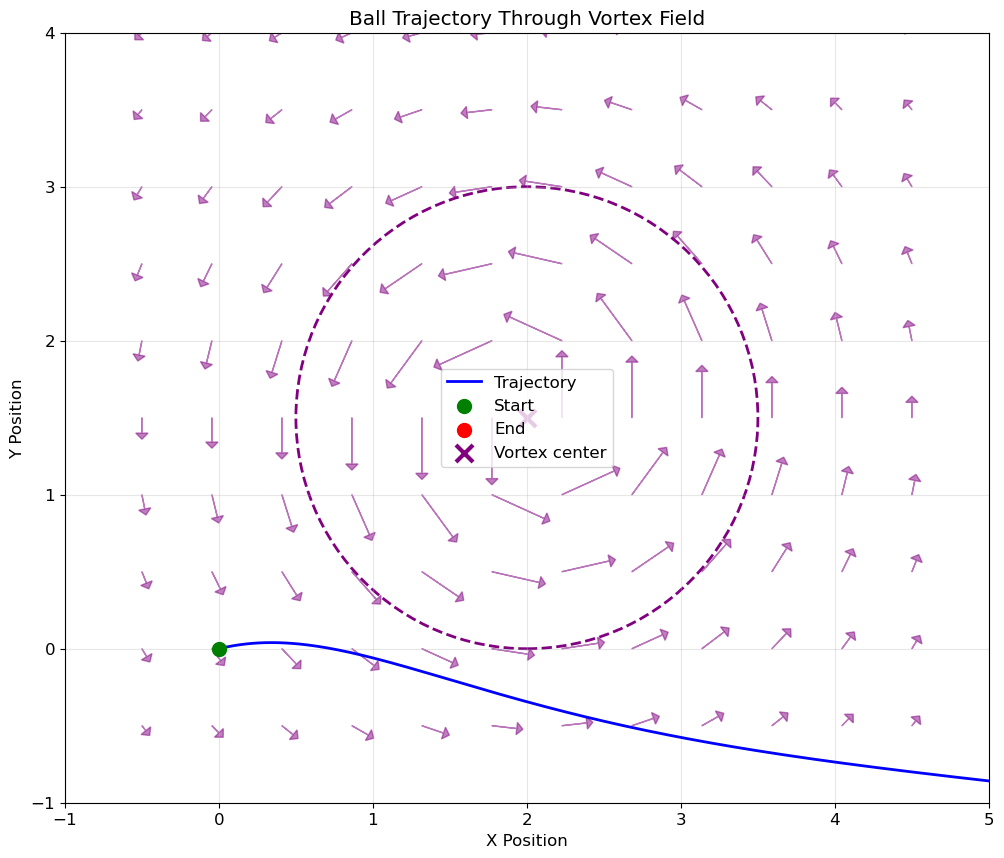

In [6]:
class VortexField:
    """Vortex/tornado force field creating rotation."""
    def __init__(self, center, strength, radius, falloff='gaussian'):
        self.center = np.array(center)
        self.strength = strength  # positive = CCW, negative = CW
        self.radius = radius
        self.falloff = falloff
    
    def compute_force(self, pos, vel):
        r_vec = pos - self.center
        distance = np.linalg.norm(r_vec)
        
        if distance < 1e-6:
            return np.array([0.0, 0.0])
        
        # Tangential direction (perpendicular to radial)
        tangent = np.array([-r_vec[1], r_vec[0]]) / distance
        
        # Falloff based on distance
        if self.falloff == 'gaussian':
            falloff = np.exp(-0.5 * (distance / self.radius) ** 2)
        elif self.falloff == 'linear':
            falloff = max(0, 1 - distance / self.radius)
        else:  # constant
            falloff = 1.0 if distance < self.radius else 0.0
        
        return self.strength * tangent * falloff

# Create a vortex
vortex = VortexField(center=(2.0, 1.5), strength=5.0, radius=1.5, falloff='gaussian')

def vortex_force(pos, vel):
    return vortex.compute_force(pos, vel)

state = PhysicsState(x=0, y=0, vx=1.2, vy=0.3)
positions, _ = simulate_simple(state, vortex_force, dt=0.01, num_steps=400)

# Visualize with force field arrows
fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(positions[:, 0], positions[:, 1], 'b-', linewidth=2, label='Trajectory')
ax.scatter([0], [0], c='green', s=100, zorder=5, label='Start')
ax.scatter([positions[-1, 0]], [positions[-1, 1]], c='red', s=100, zorder=5, label='End')

# Draw vortex center and radius
circle = Circle(vortex.center, vortex.radius, fill=False, color='purple', linewidth=2, linestyle='--')
ax.add_patch(circle)
ax.scatter([vortex.center[0]], [vortex.center[1]], c='purple', s=150, marker='x', linewidths=3, label='Vortex center')

# Draw force field arrows
for x in np.linspace(-0.5, 4.5, 12):
    for y in np.linspace(-0.5, 4, 10):
        pos = np.array([x, y])
        force = vortex.compute_force(pos, np.zeros(2))
        if np.linalg.norm(force) > 0.1:
            ax.arrow(x, y, force[0]*0.08, force[1]*0.08, head_width=0.08, head_length=0.04, 
                    fc='purple', ec='purple', alpha=0.5)

ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Ball Trajectory Through Vortex Field')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(-1, 5)
ax.set_ylim(-1, 4)
ax.set_aspect('equal')
plt.show()


### 2.3 Point Force (Attractor/Repeller)

A point force acts like a gravitational or electrostatic source. It can attract (positive strength) or repel (negative strength) with inverse-square falloff.

$$\vec{F}_{point} = \frac{\text{strength}}{r^2} \cdot \hat{r}$$


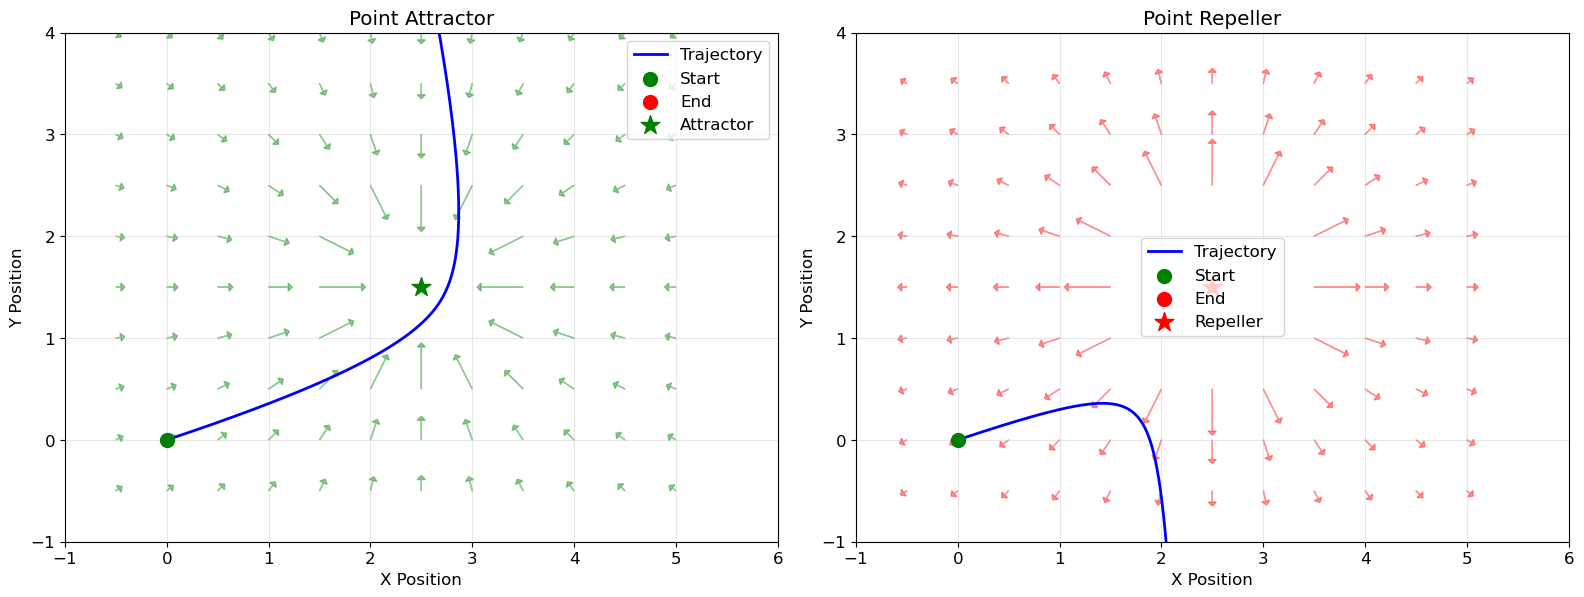

In [7]:
class PointForce:
    """Point attractor or repeller with inverse-square falloff."""
    def __init__(self, center, strength, softness=0.1):
        self.center = np.array(center)
        self.strength = strength  # positive = attractor, negative = repeller
        self.softness = softness  # prevents singularity at center
    
    def compute_force(self, pos, vel):
        r_vec = self.center - pos  # points toward center for attractor
        distance = np.linalg.norm(r_vec)
        
        if distance < 1e-6:
            return np.array([0.0, 0.0])
        
        direction = r_vec / distance
        # Softened inverse-square: F = strength / (r^2 + softness^2)
        magnitude = self.strength / (distance**2 + self.softness**2)
        
        return magnitude * direction

# Compare attractor vs repeller
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for ax, (name, strength, color) in zip(axes, [('Attractor', 3.0, 'green'), ('Repeller', -3.0, 'red')]):
    point = PointForce(center=(2.5, 1.5), strength=strength, softness=0.3)
    
    def point_force(pos, vel):
        return point.compute_force(pos, vel)
    
    state = PhysicsState(x=0, y=0, vx=1.5, vy=0.5)
    positions, _ = simulate_simple(state, point_force, dt=0.01, num_steps=300)
    
    ax.plot(positions[:, 0], positions[:, 1], 'b-', linewidth=2, label='Trajectory')
    ax.scatter([0], [0], c='green', s=100, zorder=5, label='Start')
    ax.scatter([positions[-1, 0]], [positions[-1, 1]], c='red', s=100, zorder=5, label='End')
    ax.scatter([point.center[0]], [point.center[1]], c=color, s=200, marker='*', label=name)
    
    # Draw force field
    for x in np.linspace(-0.5, 5, 12):
        for y in np.linspace(-0.5, 4, 10):
            pos = np.array([x, y])
            force = point.compute_force(pos, np.zeros(2))
            if 0.05 < np.linalg.norm(force) < 5:
                scale = 0.15
                ax.arrow(x, y, force[0]*scale, force[1]*scale, head_width=0.08, 
                        head_length=0.04, fc=color, ec=color, alpha=0.4)
    
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title(f'Point {name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-1, 6)
    ax.set_ylim(-1, 4)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()


### 2.4 Drag Zone

A drag zone applies a velocity-dependent damping force. This slows down particles passing through it.

$$\vec{F}_{drag} = -c \cdot \vec{v} \cdot \mathbb{1}_{circle}(\vec{x})$$

where $c$ is the drag coefficient.


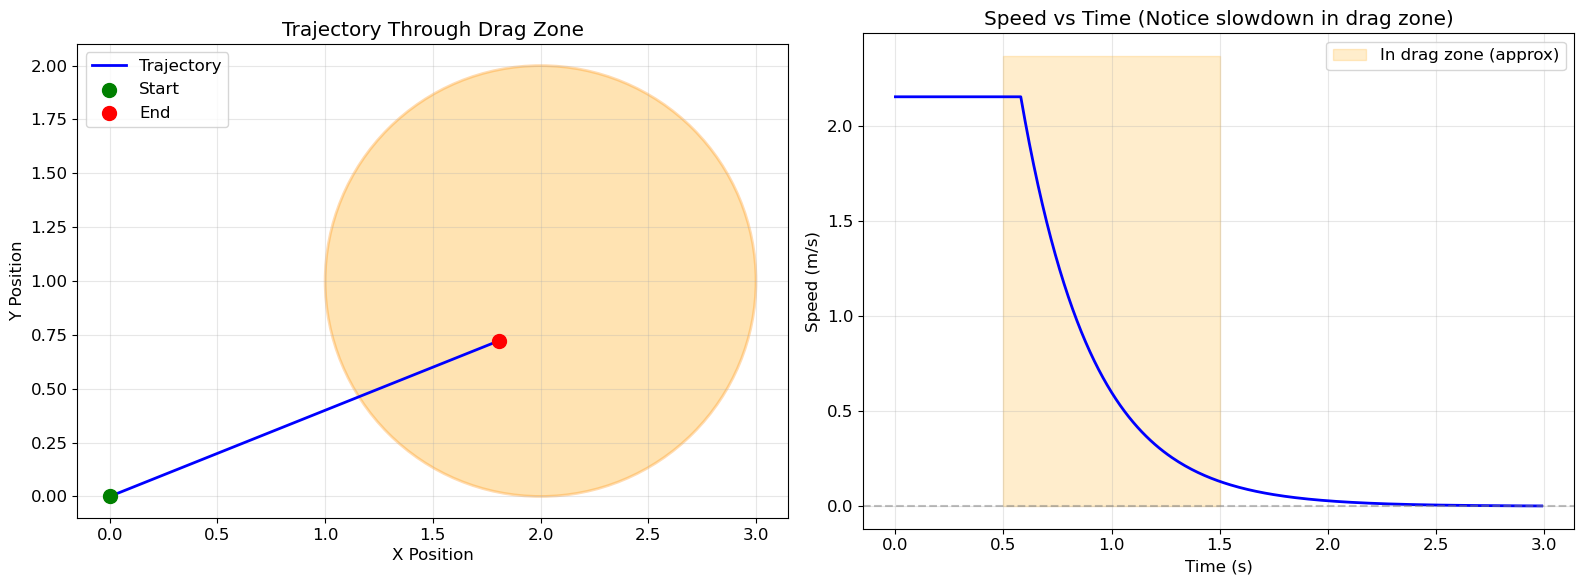

In [8]:
class DragZone:
    """Velocity-dependent damping region."""
    def __init__(self, center, radius, drag_coefficient):
        self.center = np.array(center)
        self.radius = radius
        self.drag_coefficient = drag_coefficient
    
    def compute_force(self, pos, vel):
        distance = np.linalg.norm(pos - self.center)
        if distance < self.radius:
            return -self.drag_coefficient * vel
        return np.array([0.0, 0.0])

# Simulate with drag zone
drag = DragZone(center=(2.0, 1.0), radius=1.0, drag_coefficient=3.0)

def drag_force(pos, vel):
    return drag.compute_force(pos, vel)

state = PhysicsState(x=0, y=0, vx=2.0, vy=0.8)
positions, velocities = simulate_simple(state, drag_force, dt=0.01, num_steps=300)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Trajectory plot
ax = axes[0]
ax.plot(positions[:, 0], positions[:, 1], 'b-', linewidth=2, label='Trajectory')
ax.scatter([0], [0], c='green', s=100, zorder=5, label='Start')
ax.scatter([positions[-1, 0]], [positions[-1, 1]], c='red', s=100, zorder=5, label='End')
circle = Circle(drag.center, drag.radius, fill=True, facecolor='orange', alpha=0.3, 
                edgecolor='darkorange', linewidth=2)
ax.add_patch(circle)
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Trajectory Through Drag Zone')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# Speed plot
ax = axes[1]
speeds = np.linalg.norm(velocities, axis=1)
times = np.arange(len(speeds)) * 0.01
ax.plot(times, speeds, 'b-', linewidth=2)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.fill_between([0.5, 1.5], 0, max(speeds)*1.1, alpha=0.2, color='orange', label='In drag zone (approx)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Speed (m/s)')
ax.set_title('Speed vs Time (Notice slowdown in drag zone)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Part 3: Combining Multiple Force Fields

The real power comes from combining multiple force fields! Forces are additive:

$$\vec{F}_{total} = \sum_i \vec{F}_i$$

Let's create a complex scenario with multiple fields.


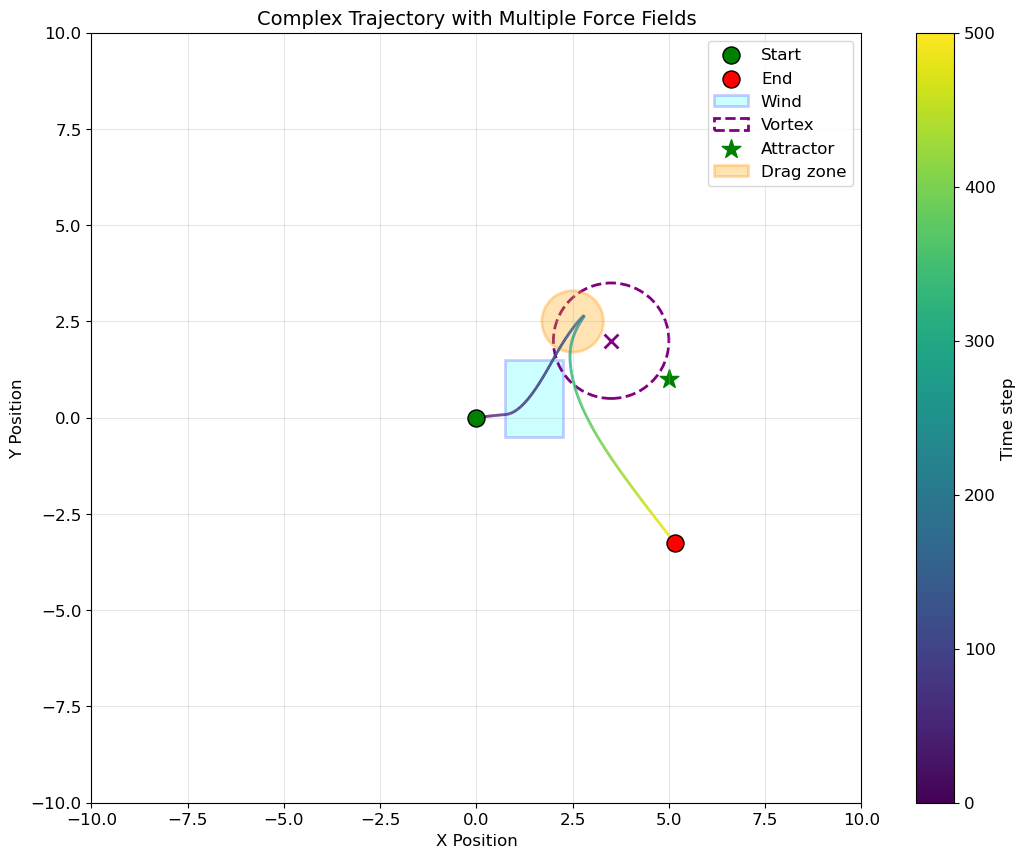

In [10]:
# Create multiple fields
fields = [
    WindField(center=(1.5, 0.5), size=(1.5, 2.0), direction=(0, 1), strength=6.0),
    VortexField(center=(3.5, 2.0), strength=4.0, radius=1.5, falloff='gaussian'),
    PointForce(center=(5.0, 1.0), strength=2.0, softness=0.3),
    DragZone(center=(2.5, 2.5), radius=0.8, drag_coefficient=2.0),
]

def combined_force(pos, vel):
    total = np.array([0.0, 0.0])
    for field in fields:
        total = total + field.compute_force(pos, vel)
    return total

state = PhysicsState(x=0, y=0, vx=1.5, vy=0.2)
positions, _ = simulate_simple(state, combined_force, dt=0.01, num_steps=500)

# Visualize everything
fig, ax = plt.subplots(figsize=(14, 10))

# Draw trajectory with color gradient for time
points = positions.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
norm = plt.Normalize(0, len(positions))
lc = LineCollection(segments, cmap='viridis', norm=norm, linewidth=2)
lc.set_array(np.arange(len(positions)))
ax.add_collection(lc)
plt.colorbar(lc, ax=ax, label='Time step')

ax.scatter([0], [0], c='green', s=150, zorder=5, label='Start', edgecolors='black')
ax.scatter([positions[-1, 0]], [positions[-1, 1]], c='red', s=150, zorder=5, label='End', edgecolors='black')

# Draw wind region
wind = fields[0]
rect = Rectangle(wind.center - wind.size/2, wind.size[0], wind.size[1], 
                 fill=True, facecolor='cyan', alpha=0.2, edgecolor='blue', linewidth=2, label='Wind')
ax.add_patch(rect)

# Draw vortex
vortex = fields[1]
circle = Circle(vortex.center, vortex.radius, fill=False, color='purple', linewidth=2, linestyle='--', label='Vortex')
ax.add_patch(circle)
ax.scatter([vortex.center[0]], [vortex.center[1]], c='purple', s=100, marker='x', linewidths=2)

# Draw attractor
attractor = fields[2]
ax.scatter([attractor.center[0]], [attractor.center[1]], c='green', s=200, marker='*', label='Attractor')

# Draw drag zone
drag = fields[3]
circle = Circle(drag.center, drag.radius, fill=True, facecolor='orange', alpha=0.3, 
                edgecolor='darkorange', linewidth=2, label='Drag zone')
ax.add_patch(circle)

ax.set_xlabel('X Position', fontsize=12)
ax.set_ylabel('Y Position', fontsize=12)
ax.set_title('Complex Trajectory with Multiple Force Fields', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_aspect('equal')
plt.show()


## Part 4: Interactive Exploration

Let's create an interactive widget to explore how changing field parameters affects the trajectory!


In [11]:
def interactive_simulation(wind_strength=5.0, wind_angle=90, vortex_strength=3.0, 
                           init_vx=1.5, init_vy=0.0):
    """Interactive simulation with adjustable parameters."""
    # Convert wind angle to direction
    angle_rad = np.radians(wind_angle)
    wind_dir = (np.cos(angle_rad), np.sin(angle_rad))
    
    fields = [
        WindField(center=(2.0, 1.0), size=(2.0, 3.0), direction=wind_dir, strength=wind_strength),
        VortexField(center=(4.0, 2.0), strength=vortex_strength, radius=1.5, falloff='gaussian'),
    ]
    
    def force(pos, vel):
        return sum(f.compute_force(pos, vel) for f in fields)
    
    state = PhysicsState(x=0, y=0, vx=init_vx, vy=init_vy)
    positions, _ = simulate_simple(state, force, dt=0.01, num_steps=400)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(positions[:, 0], positions[:, 1], 'b-', linewidth=2)
    ax.scatter([0], [0], c='green', s=100, zorder=5)
    ax.scatter([positions[-1, 0]], [positions[-1, 1]], c='red', s=100, zorder=5)
    
    # Draw fields
    wind = fields[0]
    rect = Rectangle(wind.center - wind.size/2, wind.size[0], wind.size[1], 
                     fill=True, facecolor='cyan', alpha=0.2, edgecolor='blue', linewidth=2)
    ax.add_patch(rect)
    ax.arrow(wind.center[0], wind.center[1], wind_dir[0]*0.5, wind_dir[1]*0.5,
             head_width=0.15, head_length=0.1, fc='blue', ec='blue')
    
    vortex = fields[1]
    circle = Circle(vortex.center, vortex.radius, fill=False, color='purple', linewidth=2, linestyle='--')
    ax.add_patch(circle)
    
    ax.set_xlim(-1, 8)
    ax.set_ylim(-1, 5)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_title(f'Wind: {wind_strength:.1f} @ {wind_angle}°, Vortex: {vortex_strength:.1f}')
    plt.show()

# Create interactive widget
interact(interactive_simulation,
         wind_strength=widgets.FloatSlider(min=0, max=15, step=0.5, value=5, description='Wind'),
         wind_angle=widgets.IntSlider(min=0, max=360, step=15, value=90, description='Wind Angle'),
         vortex_strength=widgets.FloatSlider(min=-10, max=10, step=0.5, value=3, description='Vortex'),
         init_vx=widgets.FloatSlider(min=0.5, max=3, step=0.1, value=1.5, description='Init Vx'),
         init_vy=widgets.FloatSlider(min=-1, max=1, step=0.1, value=0, description='Init Vy'));


interactive(children=(FloatSlider(value=5.0, description='Wind', max=15.0, step=0.5), IntSlider(value=90, desc…

## Summary

In this notebook, we learned:

1. **Basic Physics**: Position, velocity, acceleration, and Newton's second law
2. **Numerical Integration**: Semi-implicit Euler method for stable simulation
3. **Force Fields**: 
   - **Wind**: Constant directional force in a region
   - **Vortex**: Rotating tangential force
   - **Point Force**: Inverse-square attractor/repeller
   - **Drag Zone**: Velocity-dependent damping

4. **Combining Fields**: Forces add together to create complex behaviors

## Next Steps

In the next notebook, we'll make this physics simulation **differentiable** using JAX. This will allow us to:
- Compute gradients of trajectories with respect to force field parameters
- Use gradient descent to find optimal force configurations
- Train neural networks through the physics simulation

See you in **02_differentiable_simulation.ipynb**! 🚀
